# Fraud detection

## Finding people of interest and indicative language, Part 2

### The Enron Corporation
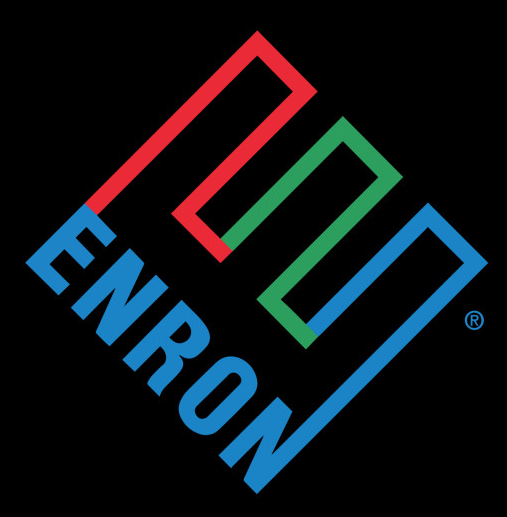

We will start where we left off before and continue exploring the data.  This notebook will also begin some of the prep we will need to get the data ready for modeling

As with any notebook we must begin by importing the libraries we'll need.

In [1]:
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from datetime import datetime
import networkx as nx
import nxviz as nv
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import maxent
import re
import os
from email.parser import Parser
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We have a number of variables to load in the notebook so we can pick up right away.  We'll load everything first and then review the headers to make sure everything ported over properly.

In [2]:
%store -r result
result.head()

,from_field,recipient_1,recipient_2,recipient_3,date,subject,body
0,msagel@home.com,jarnold@enron.com,None,None,2000-11-16,Status,John:\n?\nI'm not really sure what happened be...
1,slafontaine@globalp.com,john.arnold@enron.com,None,None,2000-12-08,re:summer inverses,i suck-hope youve made more money in natgas la...
2,iceoperations@intcx.com,icehelpdesk@intcx.com,internalmarketing@intcx.com,None,2001-05-15,The WTI Bullet swap contracts,"Hi,\n\n\n Following the e-mail you have rece..."
3,jeff.youngflesh@enron.com,anthony.gilmore@enron.com,colleen.koenig@enron.com,jennifer.stewart@enron.com,2000-11-27,Invitation: EBS/GSS Meeting w/Bristol Babcock ...,Conference Room TBD. \n\nThis meeting will be...
4,caroline.abramo@enron.com,mike.grigsby@enron.com,None,None,2000-12-12,Harvard Mgmt,Mike- I have their trader coming into the offi...


In [3]:
%store -r top_sender
top_sender =list(top_sender)
top_sender

['louise.kitchen@enron.com',
 'chris.germany@enron.com',
 'mark.taylor@enron.com',
 'sara.shackleton@enron.com',
 'debra.perlingiere@enron.com',
 'kay.mann@enron.com',
 'david.delainey@enron.com',
 'drew.fossum@enron.com',
 'chris.dorland@enron.com',
 'mike.grigsby@enron.com',
 'larry.campbell@enron.com',
 'mary.hain@enron.com',
 'mike.mcconnell@enron.com',
 'phillip.allen@enron.com',
 'jeff.dasovich@enron.com',
 'susan.scott@enron.com',
 'lynn.blair@enron.com',
 'eric.bass@enron.com',
 'gerald.nemec@enron.com',
 'richard.shapiro@enron.com',
 'scott.neal@enron.com',
 'darron.giron@enron.com',
 'john.lavorato@enron.com',
 'arsystem@mailman.enron.com',
 'enron.announcements@enron.com',
 'kate.symes@enron.com',
 'dan.hyvl@enron.com',
 'susan.mara@enron.com',
 'vince.kaminski@enron.com',
 'sally.beck@enron.com',
 'tana.jones@enron.com',
 'michelle.cash@enron.com',
 'daren.farmer@enron.com',
 'james.steffes@enron.com',
 'matthew.lenhart@enron.com',
 'mark.haedicke@enron.com',
 'jeffrey.shan

In [4]:
%store -r top_recipient
top_recipient

['genia.fitzgerald@enron.com',
 'sally.beck@enron.com',
 'greg.whalley@enron.com',
 'paul.kaufman@enron.com',
 'klay@enron.com',
 'shirley.crenshaw@enron.com',
 'jeffrey.hodge@enron.com',
 'd..steffes@enron.com',
 'jeff.skilling@enron.com',
 'bhansen@lhom.com',
 'tana.jones@enron.com',
 'mark.taylor@enron.com',
 'james.steffes@enron.com',
 'lorraine.lindberg@enron.com',
 'mary.cook@enron.com',
 'tim.belden@enron.com',
 'alan.aronowitz@enron.com',
 'linda.robertson@enron.com',
 'suzanne.adams@enron.com',
 'steven.kean@enron.com',
 'louise.kitchen@enron.com',
 'kate.symes@enron.com',
 'jeff.dasovich@enron.com',
 'susan.bailey@enron.com',
 'daren.j.farmer@enron.com',
 'kenneth.lay@enron.com',
 'john.arnold@enron.com',
 'f..brawner@enron.com',
 'john.lavorato@enron.com',
 'william.bradford@enron.com',
 'sandra.mccubbin@enron.com',
 'all.houston@enron.com',
 'benjamin.rogers@enron.com',
 'kay.mann@enron.com',
 'samantha.boyd@enron.com',
 'brent.hendry@enron.com',
 'peggy.banczak@enron.com',

In [5]:
%store -r df
df.head()

,date_time,to_field,from_field,subject,body,dates,date
0,2000-11-16 09:30:00,jarnold@enron.com,msagel@home.com,Status,John:\n?\nI'm not really sure what happened be...,2000-11-16 00:00:00,2000-11-16
1,2000-12-08 05:05:00,john.arnold@enron.com,slafontaine@globalp.com,re:summer inverses,i suck-hope youve made more money in natgas la...,2000-12-08 05:05:00,2000-12-08
2,2001-05-15 09:43:00,"icehelpdesk@intcx.com, internalmarketing@intcx...",iceoperations@intcx.com,The WTI Bullet swap contracts,"Hi,\n\n\n Following the e-mail you have rece...",2001-05-15 09:43:00,2001-05-15
3,2000-11-27 01:49:00,"anthony.gilmore@enron.com, colleen.koenig@enro...",jeff.youngflesh@enron.com,Invitation: EBS/GSS Meeting w/Bristol Babcock ...,Conference Room TBD. \n\nThis meeting will be...,2000-11-27 01:49:00,2000-11-27
4,2000-12-12 09:33:00,mike.grigsby@enron.com,caroline.abramo@enron.com,Harvard Mgmt,Mike- I have their trader coming into the offi...,2000-12-12 09:33:00,2000-12-12


Let's look at the summary statistics for the 'from' field and use that person as a test for our process.

In [6]:
result.from_field.describe()

count                 495554
unique                 19752
top       kay.mann@enron.com
freq                   16721
Name: from_field, dtype: object

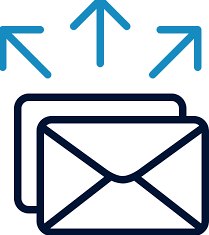

It looks like Kay Mann is the person to look at.  We can pull these emails into a separate dataframe and take a look at the shape and statistics of the individual's email traffic.

In [7]:
km_df = df[df['from_field'] ==('kay.mann@enron.com')]
km_df.describe()

,date_time,to_field,from_field,subject,body,dates,date
count,16721,16721,16721,16721,16721,16721,16721
unique,4751,956,1,3161,4868,4753,345
top,1979-12-31 16:00:00,suzanne.adams@enron.com,kay.mann@enron.com,,"Gregg,\n\nIt is my understanding that Enron an...",1979-12-31 16:00:00,2001-06-06
freq,34,1528,16721,493,6,34,240
first,NaN,NaN,NaN,NaN,NaN,1979-12-31 16:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2002-05-28 15:02:28,NaN


In [8]:
km_text=[]
for mail in km_df.body:
    km_text.append(km_df.body.values)

In order to process the text, we need to convery everythign back to a string.  

In [9]:
km_text[10]

array(["Hi Carol,\n\nI saw that you posted about getting a nanny.  I've used two services, but \nonly one that I can suggest.  For my last nanny, I used Morningside Nanny \nService, or something close to that. They seemed thorough, and found us a \nwonderful person.  I've also used River Oaks Nanny, but they sent me a nut \ncase.\n\nGood luck,\n\nKay",
       "Hi Carol,\n\nI saw that you posted about getting a nanny.  I've used two services, but \nonly one that I can suggest.  For my last nanny, I used Morningside Nanny \nService, or something close to that. They seemed thorough, and found us a \nwonderful person.  I've also used River Oaks Nanny, but they sent me a nut \ncase.\n\nGood luck,\n\nKay",
       'Meeting location to be determined.', ...,
       "Do we want to contest, if possible?\n--------------------------\nSent from my BlackBerry Wireless Handheld (www.BlackBerry.net)\n\n\n-----Original Message-----\nFrom: Germany, Chris <Chris.Germany@ENRON.com>\nTo: McMichael Jr., Ed <

In [10]:
len(km_text)

16721

In [11]:
km_email=str(km_text)
type(km_email)

str

Here we will be using a tokenizer from NLTK to process the word frequency.  Hopefully doing this will give us an idea of common email themes from Kay.  

In [12]:
#tokenized object
words= word_tokenize(km_email)

#customizing the stopwords by adding punctuation
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

#removing stop words
useful_words = [word for word in words if word not in stopwords_list]

In [13]:
#using the Frequency distribution method built into NLTK and looking at the 100 most common words
frequency = nltk.FreqDist(useful_words)
 
print(frequency.most_common(100))

[('--', 1153749), ('I', 367862), ('\\nSent', 250815), ('2002', 250815), ('-Original', 234094), ('Message', 234094), ('-\\nFrom', 234094), ('February', 234094), ('Unpaid', 183931), ('Invoice', 183931), ('Post', 183931), ('petition', 183931), ('ENA', 167210), ('Letter', 167210), ('gas', 150489), ('PM\\nTo', 150489), ('\\tDicarlo', 150489), ('Ed', 133768), ('ENRON.com', 117047), ('Jr.', 117047), ('Louis', 117047), ('TDC', 117047), ('``', 100326), ('used', 100326), ('Mann', 100326), ('Dominion', 100326), ('\\tMcMichael', 100326), ('\\tWednesday', 100326), ('\\tRE', 100326), ('need', 100326), ('\\tGermany', 100326), ("'ve", 83605), ('Boyt', 83605), ('Kay', 83605), ('deal', 83605), ('letter', 83605), ('\\tFW', 83605), ('payment', 83605), ('\\n\\nI', 66884), ('nanny', 66884), ('Nanny', 66884), ("''", 66884), ('Chris', 66884), ('stated', 66884), ('would', 66884), ('AM\\nTo', 66884), ('close', 50163), ('us', 50163), ('\\n\\nKay', 50163), ('Parks', 50163), ('Joe', 50163), ('supply', 50163), ('Ga

Awesome.  There are some odd things in here, but that's fine.  I think it would be great to see what this looks like on the whole data set.  We'll time this one because this is a process heavy step.  We'll also add some intermediary checks to ensure that we knwo the code is still running.

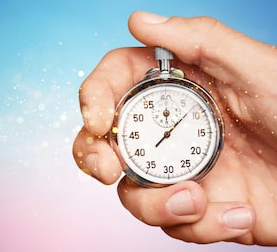

In [14]:
start = datetime.now()

text=[]
for mail in df.body:
    text.append(df.body.values)
print("checking the length\n", len(text))

email=str(text)

print("\nchecking the type\n", type(email))

words_all= word_tokenize(email)

useful_words_all = [word for word in words_all if word not in stopwords_list]
frequency_all = nltk.FreqDist(useful_words_all)
 
print("\n\n\nThe Total email 100 most common words are: \n\n",frequency_all.most_common(100))

finish = datetime.now()
elapsed = finish-start
print("\n\n{} has elapsed.".format(elapsed))

checking the length
 495554

checking the type
 <class 'str'>



The Total email 100 most common words are: 

 [('\\n', 14866620), ('--', 5946648), ('I', 4955540), ('No', 4955540), ('E-mail', 4955540), ('``', 3964432), ("''", 3964432), ('problems', 2973324), ('\\n\\n', 2477770), ('monthly', 2477770), ('number', 2477770), ('Tag', 2477770), ('Flow', 2477770), ('create', 1982216), ('would', 1982216), ('like', 1982216), ('spread', 1982216), ('+44', 1982216), ('Kathy\\n', 1982216), ('We', 1982216), ("'s", 1982216), ('half-past', 1982216), ('tag', 1982216), ('entity', 1982216), ('takes', 1982216), ('If', 1486662), ('-Deleted', 1486662), ('WTI/Brent', 1486662), ('1', 1486662), ('NYH', 1486662), ('Fuel', 1486662), ('Oil', 1486662), ('Crack', 1486662), ('need', 1486662), ('us', 1486662), ('207', 1486662), ('484', 1486662), ('one', 1486662), ('tags', 1486662), ('late', 1486662), ('think', 1486662), ('get', 1486662), ('issues', 1486662), ('resolved', 1486662), ('prior', 1486662), ('implementing',

Because of the way we parsed the emails in part one we have some characters and weird things that we need to get rid of.  We can also get rid of thinks that are related to phone numbers in people's signature blocks, such as '+44'.  That's the country code for the U.K.  I don't think that alone will help us detect fraud.  

We'll accomplish most of this by just adding to a list, then removing those again by substituting them with nothing.   

In [15]:
subs = ["\\n", "--","I","''","Messege","\\t","-Added","-Original","-Deleted","To","1","No","''","``",
        "From","...","Cc","``","'s","''","\\","``","+44","207","484","'", "5546","09","2001","53"]
start = datetime.now()
for char in subs:
    email = email.replace(char, "")

finish = datetime.now()
elapsed = finish-start
print("\n\n{} has elapsed.".format(elapsed))



0:01:49.863513 has elapsed.


Now that has been done we can run the code again, those time we can just use our timer since we're sure the code will run.

In [16]:
start = datetime.now()


words_all= word_tokenize(email)


useful_words_all = [word for word in words_all if word not in stopwords_list]
frequency_all = nltk.FreqDist(useful_words_all)
 
print("\n\n\nThe Total email 100 most common words are: \n\n",frequency_all.most_common(100))

finish = datetime.now()
elapsed = finish-start
print("\n\n{} has elapsed.".format(elapsed))




The Total email 100 most common words are: 

 [('E-mail', 4955540), ('``', 3964432), ("''", 3964432), ('Kathy', 3468878), ('problems', 2973324), ('Mark', 2477770), ('monthly', 2477770), ('late', 2477770), ('number', 2477770), ('Tag', 2477770), ('Flow', 2477770), ('Hara', 2477770), ('create', 1982216), ('would', 1982216), ('like', 1982216), ('spread', 1982216), ('We', 1982216), ('half-past', 1982216), ('tag', 1982216), ('entity', 1982216), ('takes', 1982216), ('f', 1486662), ('contracts', 1486662), ('spreads', 1486662), ('WT/Brent', 1486662), ('NYH', 1486662), ('Fuel', 1486662), ('Oil', 1486662), ('Crack', 1486662), ('need', 1486662), ('us', 1486662), ('one', 1486662), ('tags', 1486662), ('think', 1486662), ('get', 1486662), ('issues', 1486662), ('resolved', 1486662), ('prior', 1486662), ('implementing', 1486662), ('everyone', 1486662), ('Message-', 1486662), ('Sent', 1486662), ('Monday', 1486662), ('April', 1486662), ('200', 1486662), ('Subject', 1486662), ('BCHA', 1486662), ('Autom

Awesome!  This is much better looking.  In here you can already see a few things that might have indicated that something was off.  There are a lot of last names in here as well as words like 'issues' and 'pressue'.  

Let's make these top words a dictionary so we can easily plot their frequency.

In [17]:
top_words = frequency_all.most_common(100)
top_words = dict(top_words)

In [18]:
#data check
len(top_words)

100

In [19]:
x=list(top_words.keys())
y=list(top_words.values())

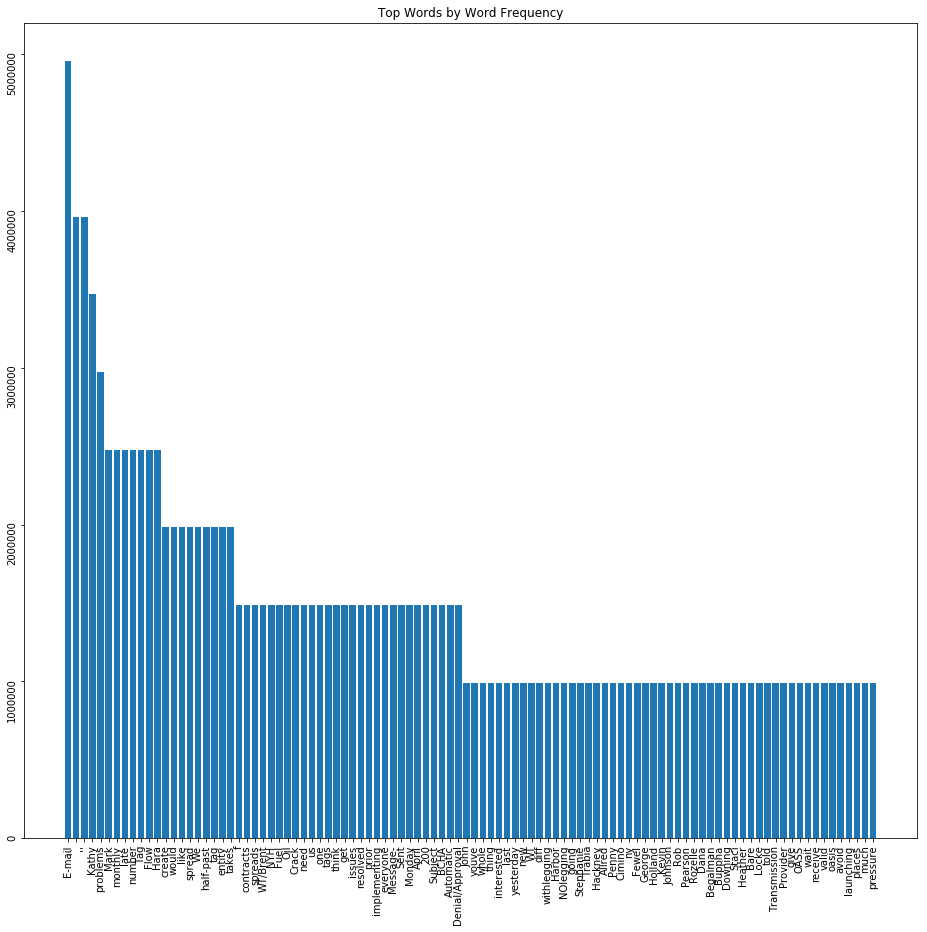

In [20]:
#plotting a bar graph of the top words
plt.figure(figsize = (16,15))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.title("Top Words by Word Frequency")
plt.show()

In my opinion this is a great way to look at the data and it makes it very easy to see if something sticks out.  An even better visualization is a word cloud.  The python library 'wordcloud' makes this very easy.

In [21]:
#converting the useful words back to a string
comment_words = str(useful_words_all)

In [22]:
#initializing the wordcloud object
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords_list, 
                min_font_size = 10).generate(comment_words)

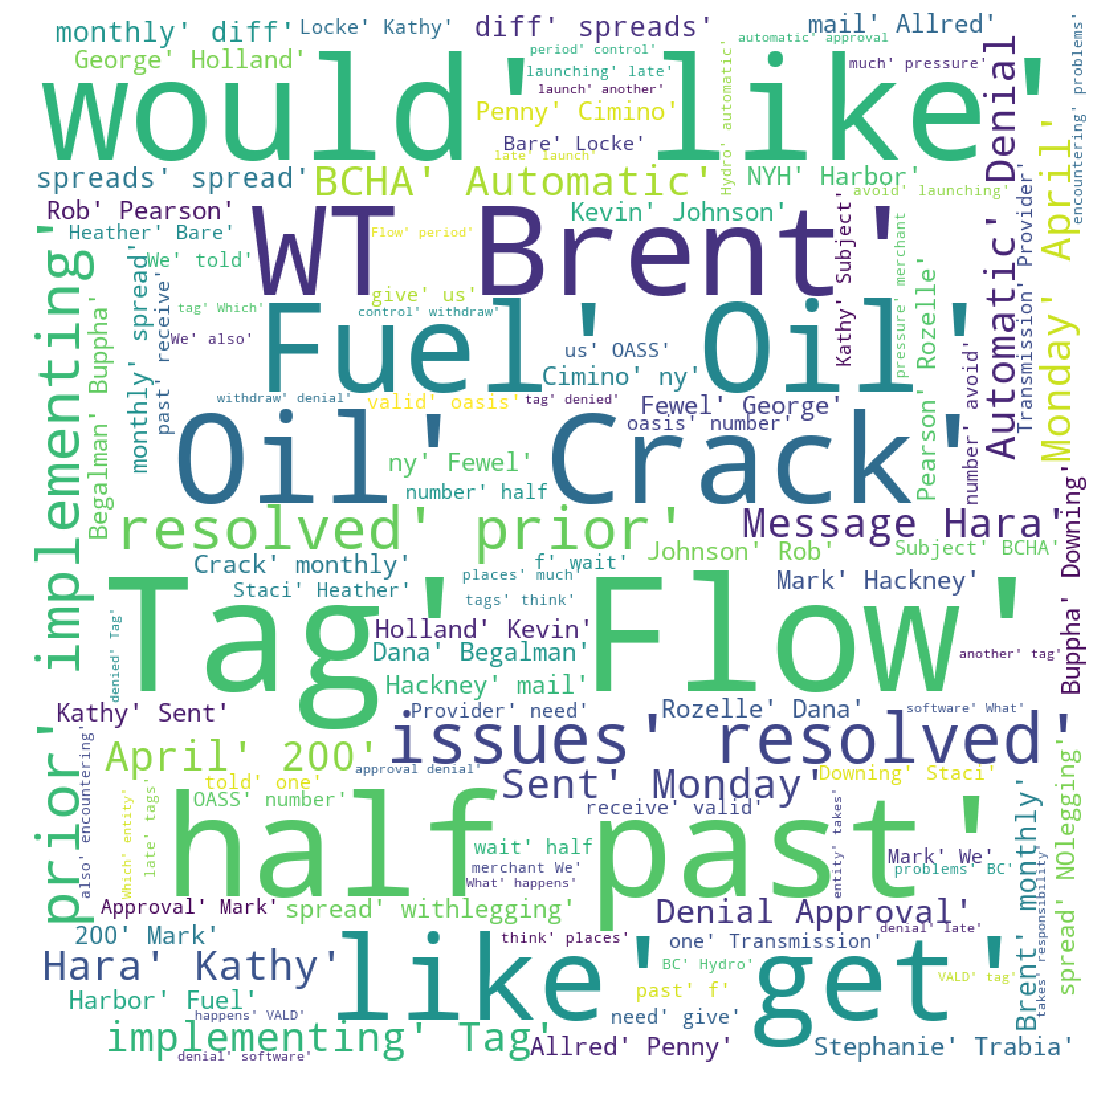

In [23]:
# plotting the WordCloud image using matplot                        
plt.figure(figsize = (15,15), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Fuel, Oil, and Flow all make sense.  However, if you loop here there are some changes we can make to get. abetter image.  We'll make everything lower case in our dictionary then replot the wordcloud.


In [24]:
top_keys =list(top_words.keys())
most_frequent={}
for key in top_keys:
    new = key.lower()
    most_frequent[new]=top_words[key]

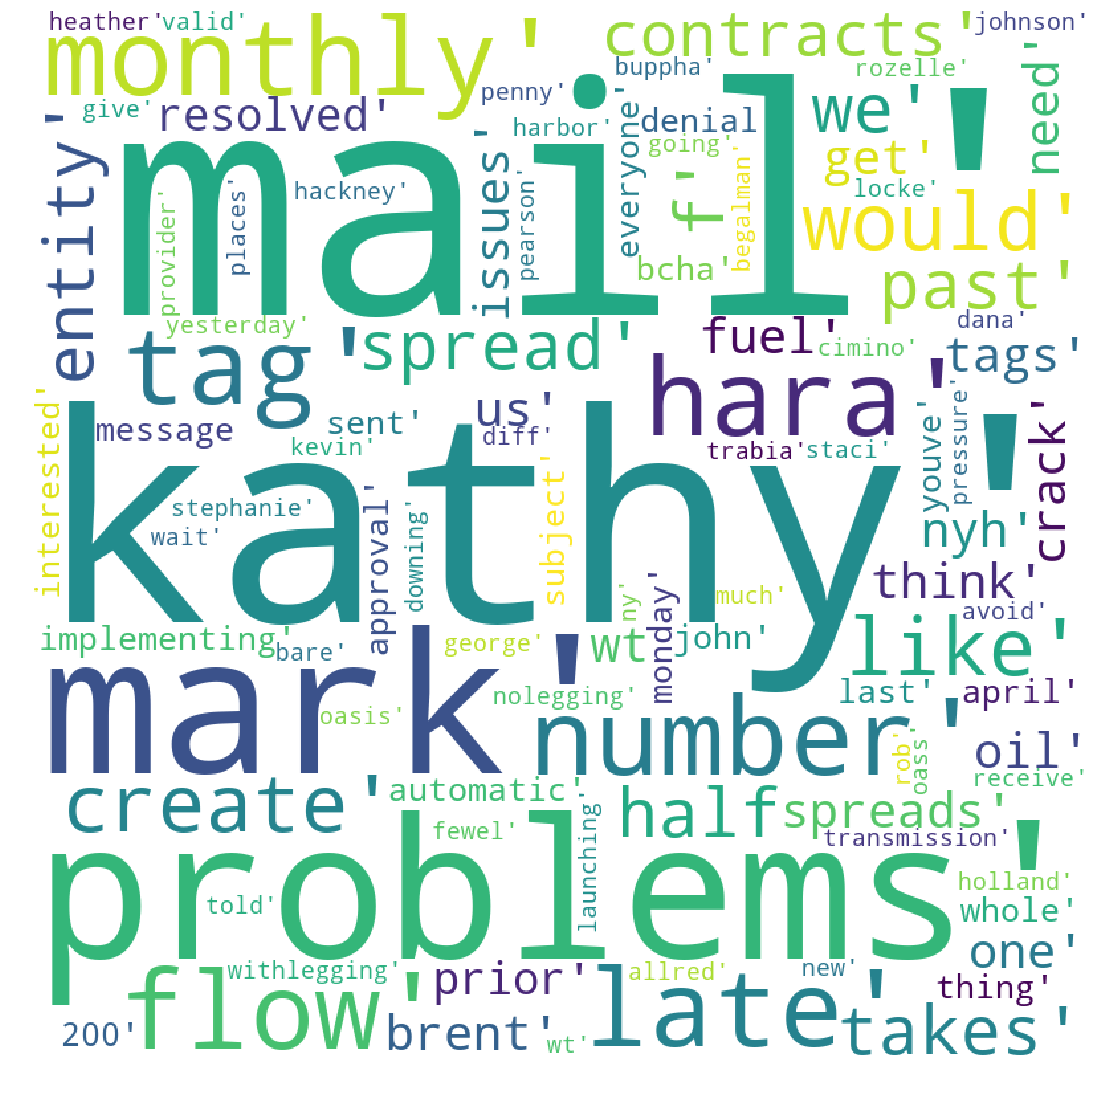

In [25]:
#creating WordCloud object
comment_words2 = str(most_frequent)
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords_list, 
                min_font_size = 10).generate(comment_words2)

# plot the WordCloud image                        
plt.figure(figsize = (15,15), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Great! It looks like we have a lot of people's names floating in there and we have a number of possible red-flag words.  

Todd Cimino was one of the Enron employees who ended up testifying agaisnt Skilling.  It makes sense that he would be relatively high on the list.  In August the US goverment seized over $200k from Kathy Lynn's personal bank accounts due to llegal transactions orchestrateded by  executives Michael Kopper and Andrew Fastow.  So again seeing 'Kathy' often also makes sense.  


We're going to move to our third notebook so before we do, we can save all the variables we might need going forward.

In [28]:
%store km_text
%store useful_words
%store frequency

Stored 'km_text' (list)
Stored 'useful_words' (list)
Stored 'frequency' (FreqDist)


In [31]:
%store top_words
%store most_frequent

Stored 'top_words' (dict)
Stored 'most_frequent' (dict)


### If you'd like to continue please move on to notebook, part 3.